In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/airbnb-recruiting-new-user-bookings/sample_submission_NDF.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/age_gender_bkts.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/test_users.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/countries.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/sessions.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')
import re
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

#sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score, ndcg_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split

# Reading Files:

In [3]:
df_train = pd.read_csv('../input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip')
df_test = pd.read_csv('../input/airbnb-recruiting-new-user-bookings/test_users.csv.zip')
countries = pd.read_csv('../input/airbnb-recruiting-new-user-bookings/countries.csv.zip')
sessions = pd.read_csv('../input/airbnb-recruiting-new-user-bookings/sessions.csv.zip')
age_gender = pd.read_csv('../input/airbnb-recruiting-new-user-bookings/age_gender_bkts.csv.zip')

In [4]:
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [5]:
df_test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [6]:
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


# EDA:

In [7]:
df_train.describe()

,timestamp_first_active,age,signup_flow
count,2.134510e+05,125461.000000,213451.000000
mean,2.013085e+13,49.668335,3.267387
std,9.253717e+09,155.666612,7.637707
min,2.009032e+13,1.000000,0.000000
25%,2.012123e+13,28.000000,0.000000
50%,2.013091e+13,34.000000,0.000000
75%,2.014031e+13,43.000000,0.000000
max,2.014063e+13,2014.000000,25.000000


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       62096 non-null  object 
 1   date_account_created     62096 non-null  object 
 2   timestamp_first_active   62096 non-null  int64  
 3   date_first_booking       0 non-null      float64
 4   gender                   62096 non-null  object 
 5   age                      33220 non-null  float64
 6   signup_method            62096 non-null  object 
 7   signup_flow              62096 non-null  int64  
 8   language                 62096 non-null  object 
 9   affiliate_channel        62096 non-null  object 
 10  affiliate_provider       62096 non-null  object 
 11  first_affiliate_tracked  62076 non-null  object 
 12  signup_app               62096 non-null  object 
 13  first_device_type        62096 non-null  object 
 14  first_browser         

In [10]:
df_train.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [11]:
df_test.isna().sum()

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         62096
gender                         0
age                        28876
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked       20
signup_app                     0
first_device_type              0
first_browser                  0
dtype: int64

In [12]:
df_train[(df_train['age'] >= 100) | (df_train['age'] <= 13)].value_counts().sum()

1335

In [13]:
df_test[(df_test['age'] >= 100) | (df_test['age'] <= 13)].value_counts().sum()

0

# Preprocessing:

## Dates:

In [14]:
def extract_date_features(df, column_name, prefix):
    """
    Extracts year, month, and day features from a date column and drops the original column.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the date column.
        column_name (str): The name of the date column to process.
        prefix (str): The prefix for the new feature columns.
    
    Returns:
        pd.DataFrame: DataFrame with extracted date features.
    """
    df[column_name] = pd.to_datetime(df[column_name], format='%Y-%m-%d', errors='coerce')
    df[f'{prefix}_year'] = df[column_name].dt.year
    df[f'{prefix}_month'] = df[column_name].dt.month
    df[f'{prefix}_day'] = df[column_name].dt.day
    return df.drop(columns=[column_name])


In [15]:
df_train = extract_date_features(df_train, 'date_account_created', 'dac')
df_test = extract_date_features(df_test, 'date_account_created', 'dac')


In [16]:
df_train.drop('date_first_booking', inplace = True, axis = 1)
df_test.drop('date_first_booking', inplace = True, axis = 1)

In [17]:
def extract_timestamp_features(df, column_name):
    """
    Extracts year, month, day, hour, minute, and second from a timestamp column.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the timestamp column.
        column_name (str): Name of the timestamp column to process.
    
    Returns:
        pd.DataFrame: DataFrame with extracted features.
    """
    # Ensure the column is a string
    df[column_name] = df[column_name].astype(str)
    
    # Extract features
    df[f'{column_name}_year'] = df[column_name].str[:4].astype(int)
    df[f'{column_name}_month'] = df[column_name].str[4:6].astype(int)
    df[f'{column_name}_day'] = df[column_name].str[6:8].astype(int)
    df[f'{column_name}_hour'] = df[column_name].str[8:10].astype(int)
    df[f'{column_name}_minute'] = df[column_name].str[10:12].astype(int)
    df[f'{column_name}_second'] = df[column_name].str[12:14].astype(int)
    
    # Optionally, drop the original timestamp column
    df = df.drop([column_name], axis=1)
    
    return df

In [18]:
df_train = extract_timestamp_features(df_train, 'timestamp_first_active')
df_test = extract_timestamp_features(df_test, 'timestamp_first_active')

## Sessions:

In [19]:
sessions = sessions.groupby("user_id", as_index= False).agg(lambda x:x.tolist())

In [20]:
def convert_to_set(device):
    device = [str(i) for i in device]
    device = [re.sub("nan","",i) for i in device]
    device = ",".join(set(device))
    
    return device

def convert_the_time(time):
    
    float_time = []
    time = [str(i) for i in time]
    time = [re.sub("nan","",i) for i in time]
    
    for i in time:
        try:
            float_time.append(float(i))
        except ValueError :
            continue


    time = sum(float_time)
    
    return time

def convert_to_string(action):
    action = [str(i) for i in action]
    action = [re.sub("nan","",i) for i in action]
    action = ",".join(action)
    
    return action

In [21]:
sessions["action"] = sessions["action"].apply(convert_to_string)
sessions["action_type"] = sessions["action_type"].apply(convert_to_string)
sessions["action_detail"] = sessions["action_detail"].apply(convert_to_string)
sessions['device_type'] =sessions['device_type'].apply(convert_to_set)
sessions['secs_elapsed'] = sessions['secs_elapsed'].apply(convert_the_time)

In [22]:
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,00023iyk9l,"index,dashboard,header_userpic,dashboard,callb...","view,view,data,view,partner_callback,message_p...","view_search_results,dashboard,header_userpic,d...","Mac Desktop,iPhone",867896.0
1,0010k6l0om,"search_results,show,personalize,show,search_re...","click,view,data,,click,click,,data,view,partne...","view_search_results,p3,wishlist_content_update...",Mac Desktop,586543.0
2,001wyh0pz8,"search,search,search,show,social_connections,i...","click,click,click,view,data,-unknown-,view,-un...","view_search_results,view_search_results,view_s...",Android App Unknown Phone/Tablet,282965.0
3,0028jgx1x1,"show,reviews,show,search,show,search,reviews,c...","view,data,view,click,view,click,data,submit,-u...","user_profile,listing_reviews,p3,view_search_re...","-unknown-,Android Phone",297010.0
4,002qnbzfs5,"social_connections,payment_methods,create,show...","data,-unknown-,-unknown-,view,data,data,data,,...","user_social_connections,-unknown-,-unknown-,us...","-unknown-,iPhone",6487080.0


# Encoding:

In [23]:
X_df_train, X_df_val, y_train, y_val = train_test_split(df_train.drop(columns=['country_destination']), df_train['country_destination'],
                                                        test_size=0.2, random_state=42, stratify=df_train['country_destination'])

## Merging With Sessions:

In [24]:
X_df_train = X_df_train.merge(sessions, left_on='id', right_on='user_id', how='left')
X_df_val = X_df_val.merge(sessions, left_on='id', right_on='user_id', how='left')
df_test = df_test.merge(sessions, left_on='id', right_on='user_id', how='left')

## Age:

In [25]:
X_df_train.loc[(X_df_train['age'] >= 100) | (X_df_train['age'] <= 15), 'age'] = np.median(X_df_train['age'].dropna())
X_df_val.loc[(X_df_val['age'] >= 100) | (X_df_val['age'] <= 15), 'age'] = np.median(X_df_val['age'].dropna())
df_test.loc[(df_test['age'] >= 100) | (df_test['age'] <= 15), 'age'] = np.median(df_train['age'].dropna())

In [26]:
def age_binning(age):
    if 18 < age <= 20:
        return '18 - 20'
    elif 20 < age <= 25:
        return '20 - 25'
    elif 25 < age <= 30:
        return '25 - 30'
    elif 30 < age <= 35:
        return '30 - 35'
    elif 35 < age <= 40:
        return '35 - 40'
    elif 40 < age <= 45:
        return '40 - 45'
    elif 45 < age <= 50:
        return '45 - 50'
    elif 50 < age <= 55:
        return '50 - 55'
    elif 55 < age <= 60:
        return '55 - 60'
    elif 60 < age <= 65:
        return '60 - 65'
    elif 65 < age <= 70:
        return '65 - 70'
    elif 70 < age <= 75:
        return '70 - 75'
    elif 75 < age <= 80:
        return '75 - 80'
    elif 80 < age <= 85:
        return '80 - 85'
    elif 85 < age <= 90:
        return '85 - 90'
    elif 90 < age <= 95:
        return '90 - 95'
    elif 95 < age <= 100:
        return '95 - 100'
    else:
        return np.nan


In [27]:
df_train['member_age_bins'] = df_train['age'].apply(age_binning)
df_test['member_age_bins'] = df_test['age'].apply(age_binning)

In [28]:
X_df_train.isna().sum()

id                                    0
gender                                0
age                               70383
signup_method                         0
signup_flow                           0
language                              0
affiliate_channel                     0
affiliate_provider                    0
first_affiliate_tracked            4793
signup_app                            0
first_device_type                     0
first_browser                         0
dac_year                              0
dac_month                             0
dac_day                               0
timestamp_first_active_year           0
timestamp_first_active_month          0
timestamp_first_active_day            0
timestamp_first_active_hour           0
timestamp_first_active_minute         0
timestamp_first_active_second         0
user_id                          111798
action                           111798
action_type                      111798
action_detail                    111798


In [29]:
X_df_val.isna().sum()

id                                   0
gender                               0
age                              17607
signup_method                        0
signup_flow                          0
language                             0
affiliate_channel                    0
affiliate_provider                   0
first_affiliate_tracked           1272
signup_app                           0
first_device_type                    0
first_browser                        0
dac_year                             0
dac_month                            0
dac_day                              0
timestamp_first_active_year          0
timestamp_first_active_month         0
timestamp_first_active_day           0
timestamp_first_active_hour          0
timestamp_first_active_minute        0
timestamp_first_active_second        0
user_id                          27838
action                           27838
action_type                      27838
action_detail                    27838
device_type              

## Missing Strings:

In [30]:
def fill_missing_values(X_df_train, X_df_val, df_test, text_columns, numeric_column):
    """
    Fills missing values in text columns with 'na' and in a numeric column with 0.

    Args:
        X_df_train (pd.DataFrame): Training dataframe.
        X_df_val (pd.DataFrame): Validation dataframe.
        df_test (pd.DataFrame): Test dataframe.
        text_columns (list): List of text column names to fill with 'na'.
        numeric_column (str): Name of numeric column to fill with 0.

    Returns:
        tuple: Transformed versions of (X_df_train, X_df_val, df_test)
    """
    for df in [X_df_train, X_df_val, df_test]:
        df[text_columns] = df[text_columns].fillna("na")
        df[numeric_column] = df[numeric_column].fillna(0)
    
    return X_df_train, X_df_val, df_test

In [31]:
def tokens(x):
    return x.split(',')

In [32]:
def fit_transform_tfidf(X_df_train, X_df_val, df_test, columns):
    """
    Fits a TF-IDF vectorizer on selected text columns of X_df_train and transforms X_df_val & df_test.
    Adds transformed features to the original dataframes and removes the original text columns.

    Args:
        X_df_train (pd.DataFrame): Training dataframe.
        X_df_val (pd.DataFrame): Validation dataframe.
        df_test (pd.DataFrame): Test dataframe.
        columns (list): List of text column names to apply TF-IDF.

    Returns:
        tuple: Transformed versions of (X_df_train, X_df_val, df_test)
    """
    vectorizers = {}  # Store vectorizers for each column
    transformed_data = {'train': [], 'val': [], 'test': []}

    for col in columns:
        vectorizer = TfidfVectorizer(min_df= 10, max_features = 5000, tokenizer = tokens)
        X_train_tfidf = vectorizer.fit_transform(X_df_train[col].astype(str))  # Fit on training data
        X_val_tfidf = vectorizer.transform(X_df_val[col].astype(str))  # Transform validation data
        X_test_tfidf = vectorizer.transform(df_test[col].astype(str))  # Transform test data

        vectorizers[col] = vectorizer
        transformed_data['train'].append(X_train_tfidf)
        transformed_data['val'].append(X_val_tfidf)
        transformed_data['test'].append(X_test_tfidf)

    # Stack transformed columns horizontally
    X_train_tfidf = hstack(transformed_data['train'])
    X_val_tfidf = hstack(transformed_data['val'])
    X_test_tfidf = hstack(transformed_data['test'])

    # Convert sparse matrices to DataFrame
    train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), index=X_df_train.index)
    val_tfidf_df = pd.DataFrame(X_val_tfidf.toarray(), index=X_df_val.index)
    test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), index=df_test.index)

    # Concatenate new TF-IDF features with original dataframe (excluding original text columns)
    X_df_train = pd.concat([X_df_train.drop(columns, axis=1), train_tfidf_df], axis=1)
    X_df_val = pd.concat([X_df_val.drop(columns, axis=1), val_tfidf_df], axis=1)
    df_test = pd.concat([df_test.drop(columns, axis=1), test_tfidf_df], axis=1)

    return X_df_train, X_df_val, df_test


In [33]:
columns_to_vectorize = ['action', 'action_type', 'action_detail']
X_df_train, X_df_val, df_test = fit_transform_tfidf(X_df_train, X_df_val, df_test, columns_to_vectorize)

In [34]:
#Keeping ID
train_id = X_df_train['id']
val_id = X_df_val['id']
test_id = df_test['id']

In [35]:
X_train = X_df_train.drop(columns=['id', 'user_id'], inplace=False)
X_val = X_df_val.drop(columns=['id', 'user_id'], inplace=False)
X_test = df_test.drop(columns=['id', 'user_id'], inplace=False)

In [36]:
def encode_categorical_features(X_train, X_val, X_test, cat_cols):
    """
    Encodes categorical features using One-Hot Encoding (OHE) for low-cardinality features
    and Label Encoding for high-cardinality features.

    Parameters:
        X_train (DataFrame): Training data
        X_val (DataFrame): Validation data
        X_test (DataFrame): Test data
        cat_cols (list): List of categorical column names

    Returns:
        X_train, X_val, X_test (DataFrame): Transformed datasets
        label_encoders (dict): Dictionary of label encoders for high-cardinality features
    """

    # Ensure categorical columns exist in all datasets
    cat_cols = [col for col in cat_cols if col in X_train.columns]

    # Separate columns based on the number of unique categories
    one_hot_cols = [col for col in cat_cols if X_train[col].nunique() < 5]
    label_encode_cols = [col for col in cat_cols if X_train[col].nunique() >= 5]

    # One-Hot Encoding for low-cardinality features
    if one_hot_cols:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train[one_hot_cols]), 
                                   columns=ohe.get_feature_names_out(one_hot_cols))
        X_val_ohe = pd.DataFrame(ohe.transform(X_val[one_hot_cols]), 
                                 columns=ohe.get_feature_names_out(one_hot_cols))
        X_test_ohe = pd.DataFrame(ohe.transform(X_test[one_hot_cols]), 
                                  columns=ohe.get_feature_names_out(one_hot_cols))
        # Drop original categorical columns and merge OHE results
        X_train = X_train.drop(columns=one_hot_cols, errors='ignore').reset_index(drop=True).join(X_train_ohe)
        X_val = X_val.drop(columns=one_hot_cols, errors='ignore').reset_index(drop=True).join(X_val_ohe)
        X_test = X_test.drop(columns=one_hot_cols, errors='ignore').reset_index(drop=True).join(X_test_ohe)

    # Label Encoding for high-cardinality features
    label_encoders = {}
    for col in label_encode_cols:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_val[col] = X_val[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
        X_test[col] = X_test[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
        label_encoders[col] = le  # Store encoder for inverse transform if needed

    return X_train, X_val, X_test, label_encoders


In [37]:
cat_cols = ['gender', 'signup_method', 'language', 'affiliate_channel', 
            'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 
            'first_device_type', 'first_browser', 'member_age_bins', 'device_type',]

# Encode categorical features for all datasets
X_train, X_val, X_test, label_encoders = encode_categorical_features(X_train, X_val, X_test, cat_cols)


### Imbalance

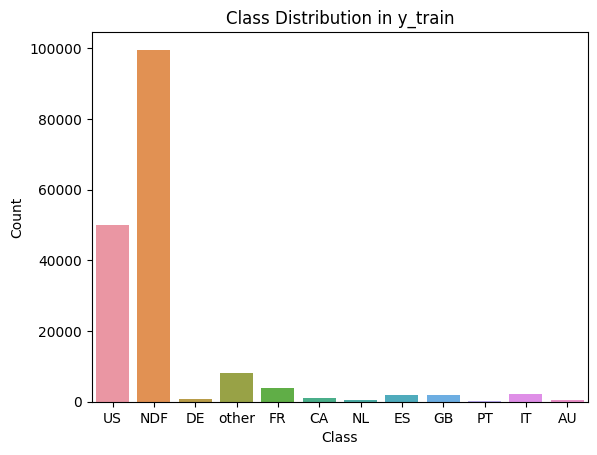

In [38]:
# Plot the distribution of the target variable
sns.countplot(x=y_train)
plt.title('Class Distribution in y_train')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [39]:
class_distribution = y_train.value_counts()

# Get the proportion of each class
class_proportions = y_train.value_counts(normalize=True)*100
print(class_proportions)

country_destination
NDF      58.347388
US       29.222886
other     4.728859
FR        2.353010
IT        1.328180
GB        1.088662
ES        1.053525
CA        0.668775
DE        0.497189
NL        0.357227
AU        0.252401
PT        0.101897
Name: proportion, dtype: float64


In [40]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

print("Encoded y_train:", y_val_encoded[:5])

Encoded y_train: [7 7 7 7 6]


In [41]:
X_test.drop(['member_age_bins'], axis = 1, inplace = True)

# Model:

In [42]:
xgb = XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=np.nan, monotone_constraints=None,
              n_estimators=25, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=0, subsample=0.5,
              tree_method=None, validate_parameters=False, verbosity=None)

xgb.fit(X_train, y_train_encoded)

y_pred = xgb.predict_proba(X_test)


In [43]:
y_pred_train = xgb.predict_proba(X_train)
y_pred_val = xgb.predict_proba(X_val)

In [44]:
def compute_ndcg(y_true, y_pred, k=5):
    """
    Computes the NDCG@k score for multi-class classification.

    Parameters:
        y_true (array-like): Ground truth labels, must be encoded as integers.
        y_pred (array-like): Predicted probabilities (output of predict_proba).
        k (int): The number of top predictions to consider for NDCG calculation.
    
    Returns:
        float: The NDCG@k score.
    """
    # Convert y_true to binary indicator format
    label_binarizer = LabelBinarizer()
    y_true_binarized = label_binarizer.fit_transform(y_true)

    # Compute NDCG@k
    ndcg_score_value = ndcg_score(y_true_binarized, y_pred, k=k)

    return ndcg_score_value

In [45]:
ndcg_train_score = compute_ndcg(y_train_encoded, y_pred_train, k=5)
print(f"NDCG@5 Score on Training Data: {ndcg_train_score:.4f}")

ndcg_val_score = compute_ndcg(y_val_encoded, y_pred_val, k=5)
print(f"NDCG@5 Score on Val Data: {ndcg_val_score:.4f}")

NDCG@5 Score on Training Data: 0.8399
NDCG@5 Score on Val Data: 0.8316


# Submission:

In [46]:
ids = []
cts = []
for i in range(len(test_id)):
    idx = test_id[i]
    ids += [idx] * 5
    cts += label_encoder.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('submission.csv',index=False)